# Ploting of the radius-related 

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import fitsio
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import vaex as vx
import easyaccess as ea
from descolors import BAND_COLORS
%matplotlib inline

In [2]:
def get_all(pattern, columns=None):
    """ Function to get the FITS files into a single record array
    """
    if (not isinstance(columns, list)):
        print("If no list of keys is input, then all are retrieved")
    counter = True
    t0 = time.time()
    for root, dirnm, filenm in os.walk(os.getcwd()):
        for idx, f in enumerate(filenm):
            if (pattern in f):
                # Get the file extension
                aux_fnm, aux_extension = os.path.splitext(f)
                if (aux_extension.upper() == ".FITS"):
                    hdu = fitsio.FITS(f)
                    if counter:
                        if (columns is None):
                            r_arr = hdu[1].read()
                        else:
                            r_arr = hdu[1].read()[columns]
                        counter = False
                    else:
                        if (columns is None):
                            r_arr = np.concatenate((r_arr, hdu[1].read()))
                        else:
                            r_arr = np.concatenate((r_arr, hdu[1].read()[columns]))
                    hdu.close()
                    print("{0} loaded".format(f))
                elif ((aux_extension.upper == ".h5") or (aux_extension.upper == ".hdf5")):
                    
                    
                    pass
                    # load the entire file and then subsample inside the df
                    
                    
                else:
                    print("ERROR")
    print("Elapsed time in reading the FITS: {0:.2f} min".format((time.time() - t0) / 60.))
    return r_arr

In [3]:
tab = get_all("Y3A2_COADD_SUMMARY_fluxaper_radius_magauto21_flags.fits")

If no list of keys is input, then all are retrieved
Y3A2_COADD_SUMMARY_fluxaper_radius_magauto21_flags.fits loaded
Elapsed time in reading the FITS: 0.01 min


## FITS are loaded in big-endian, and pandas needs it in little-endian, so must change it

In [4]:
tab = tab.byteswap().newbyteorder()

## Fill the dataframe

In [5]:
kw0 = tab.dtype.names
val0 = [tab[i] for i in kw0]
d = dict(zip(kw0, val0))

In [6]:
df = pd.DataFrame(d)
print("First set of columns: {0}".format(df.columns[:50]))

First set of columns: Index(['COADD_OBJECT_ID', 'EXT_WAVG', 'FLAGS_G', 'FLAGS_I', 'FLAGS_R',
       'FLAGS_Y', 'FLAGS_Z', 'G_FLUX_APER_1', 'G_FLUX_APER_10',
       'G_FLUX_APER_11', 'G_FLUX_APER_12', 'G_FLUX_APER_2', 'G_FLUX_APER_3',
       'G_FLUX_APER_4', 'G_FLUX_APER_5', 'G_FLUX_APER_6', 'G_FLUX_APER_7',
       'G_FLUX_APER_8', 'G_FLUX_APER_9', 'G_FLUX_RADIUS', 'G_FWHMPSF_IMAGE',
       'G_FWHM_IMAGE', 'G_KRON_RADIUS', 'G_MAG_AUTO', 'G_PETRO_RADIUS',
       'IMAFLAGS_ISO_G', 'IMAFLAGS_ISO_I', 'IMAFLAGS_ISO_R', 'IMAFLAGS_ISO_Y',
       'IMAFLAGS_ISO_Z', 'I_FLUX_APER_1', 'I_FLUX_APER_10', 'I_FLUX_APER_11',
       'I_FLUX_APER_12', 'I_FLUX_APER_2', 'I_FLUX_APER_3', 'I_FLUX_APER_4',
       'I_FLUX_APER_5', 'I_FLUX_APER_6', 'I_FLUX_APER_7', 'I_FLUX_APER_8',
       'I_FLUX_APER_9', 'I_FLUX_RADIUS', 'I_FWHMPSF_IMAGE', 'I_FWHM_IMAGE',
       'I_KRON_RADIUS', 'I_MAG_AUTO', 'I_PETRO_RADIUS', 'R_FLUX_APER_1',
       'R_FLUX_APER_10'],
      dtype='object')


### Apply flags for all bands

In [7]:
def sel_flag(df, EXT_CL=None, FLAGS=3, IMAFLAGS=0, bands=["g", "r", "i", "z", "Y"]):
    """ Make a selection on the SExtractor flags and coadd imaflags
    """
    dfaux = df.copy(deep=True)
    for band in bands:
        aux_FLAGS = "FLAGS_{0}".format(band.upper())
        aux_IMAFLAGS = "IMAFLAGS_ISO_{0}".format(band.upper())
        cond = ((df["EXT_WAVG"] == EXT_CL) & (df[aux_FLAGS] <= FLAGS) & (df[aux_IMAFLAGS] == IMAFLAGS))
        dfaux = dfaux.loc[cond]
    dfaux.reset_index(drop=True, inplace=True)
    return dfaux

In [8]:
df_aux0 = sel_flag(df, EXT_CL=0)
df_aux3 = sel_flag(df, EXT_CL=3)

### Do the plots

In [9]:
bs = ["g", "r", "i", "z", "Y"]
ap = np.arange(1, 13)

In [12]:
def plot_var(DF, CLASS=None, FLAGS=None):
    for band in bs:

        fig, ax = plt.subplots(2, 5, figsize=(16, 9))
        
        # Auxiliary labels for columns
        magauto = "{0}_MAG_AUTO".format(band.upper())
        petro = "{0}_PETRO_RADIUS".format(band.upper())
        kron = "{0}_KRON_RADIUS".format(band.upper())
        fluxrad = "{0}_FLUX_RADIUS".format(band.upper())
        fwhm = "{0}_FWHM_IMAGE".format(band.upper())
        if (CLASS == 0):
            aperX = "{0}_FLUX_APER_8".format(band.upper())
        elif (CLASS == 3):
            aperX = "{0}_FLUX_APER_4".format(band.upper())
        
        kw_r1 = {
            "bins": 80,
            "cmin": 1,
            "cmap": "jet",
        }
        # Plot first row using 2D histograms
        ax[0, 0].hist2d(DF[petro], DF[magauto], **kw_r1)
        ax[0, 1].hist2d(DF[kron], DF[magauto], **kw_r1)
        ax[0, 2].hist2d(DF[fluxrad], DF[magauto], **kw_r1)
        ax[0, 3].hist2d(-2.5 * np.log10(DF[aperX]) + 30., DF[magauto], **kw_r1)
        ax[0, 4].hist2d(DF[fwhm], DF[fluxrad], **kw_r1)
        
        # Plot second row using the histograms for the first row quantities
        kw_r2 = {
            "histtype": "step",
            "color": BAND_COLORS[band],
            "lw": 2,
        }
        w = np.ones_like(DF[petro].values) / len(DF.index)
        #
        h0, bin0 = np.histogram(DF[petro], bins="auto")
        ax[1, 0].hist(DF[petro], bins=h0.size, weights=w, **kw_r2)
        #
        h1, bin1 = np.histogram(DF[kron], bins="auto")
        ax[1, 1].hist(DF[kron], bins=h1.size * 10, weights=w, **kw_r2)
        #
        h2, bin2 = np.histogram(DF[fluxrad], bins="auto")
        ax[1, 2].hist(DF[fluxrad], bins=h2.size, weights=w, **kw_r2)  
        #
        h3, bin3 = np.histogram(DF[magauto] / (-2.5 * np.log10(DF[aperX]) + 30.), bins="auto")
        ax[1, 3].hist(DF[magauto] / (-2.5 * np.log10(DF[aperX]) + 30.), bins=h3.size, weights=w, **kw_r2)
        #
        h4, bin4 = np.histogram(DF[fwhm] / DF[fluxrad], bins="auto")
        ax[1, 4].hist(DF[fwhm] / DF[fluxrad], bins=h4.size, weights=w, **kw_r2)
        
        # Vertical line in mean
        # ax[1, 4].
        ff = "{0}: {1} / {2}".format(band, np.mean(DF[fwhm].values / DF[fluxrad].values), np.median(DF[fwhm].values / DF[fluxrad].values))
        print(ff)
        
        # First row labels
        ax[0, 0].set_xlabel(petro)
        ax[0, 1].set_xlabel(kron)
        ax[0, 2].set_xlabel(fluxrad)
        ax[0, 3].set_xlabel(r"$-2.5\ \log$({0})$ + 30$".format(aperX))
        ax[0, 4].set_xlabel(fluxrad)
        ax[0, 0].set_ylabel(magauto)
        ax[0, 1].set_ylabel(magauto)
        ax[0, 2].set_ylabel(magauto)
        ax[0, 3].set_ylabel(magauto)
        ax[0, 4].set_ylabel(fwhm)
        
        # Second row labels
        ax[1, 0].set_xlabel(petro)
        ax[1, 1].set_xlabel(kron)
        ax[1, 2].set_xlabel(fluxrad)
        ax[1, 3].set_xlabel("{0}/\n -2.5 log({1}) + 30.".format(magauto, aperX))
        ax[1, 4].set_xlabel("{0}/\n{1}".format(fwhm, fluxrad))
        ax[1, 0].set_ylabel(r"N$_{norm}$")
        ax[1, 1].set_ylabel(r"N$_{norm}$")
        ax[1, 2].set_ylabel(r"N$_{norm}$")
        ax[1, 3].set_ylabel(r"N$_{norm}$")
        ax[1, 4].set_ylabel(r"N$_{norm}$")

        # Set minor ticks
        for ax_row in ax:
            for ax_col_idx in range(ax_row.shape[0]):
                # Use Auto Minor Locator
                minorLocator_x = AutoMinorLocator()
                ax_row[ax_col_idx].xaxis.set_minor_locator(minorLocator_x)
                minorLocator_y = AutoMinorLocator()
                ax_row[ax_col_idx].yaxis.set_minor_locator(minorLocator_y)
        
        # Set limits
        ax[0, 0].set_xlim([2, 12])
        ax[1, 0].set_xlim([2, 12])
        ax[0, 1].set_xlim([3, 6])
        ax[1, 1].set_xlim([3, 6])
        ax[0, 2].set_xlim([0, 50])
        ax[1, 2].set_xlim([1, 5])
        if (CLASS == 0):
            ax[1, 3].set_xlim([0.99, 1.01])
        elif (CLASS == 3):
            ax[1, 3].set_xlim([0.95, 1.01])
        ax[1, 4].set_xlim([1, 2.5])

        # Set title
        tt = "{0}-band comparison plots.".format(band)
        tt += " Sample of {0:.1E} objects.\n MAG_AUTO_{1} < 21, EXT_WAVG={2},".format(len(DF.index), 
                                                                                      band.upper(), 
                                                                                      CLASS)
        tt += " FLAGS_{0}<={1}, IMAFLAGS_ISO_{0}=0".format(band.upper(), FLAGS)
        plt.suptitle(tt)
        
        plt.subplots_adjust(left=0.04, top=0.92, right=0.98, bottom=0.1, hspace=0.2, wspace=0.3)
        
        outnm = "radius_{0}_ext{1}_flags{2}.png".format(band, CLASS, FLAGS)
        plt.savefig(outnm, dpi=500, format="png")
        
        plt.show()

### For Class Galaxies

g: 1.7104764837182909 / 1.705739584491268


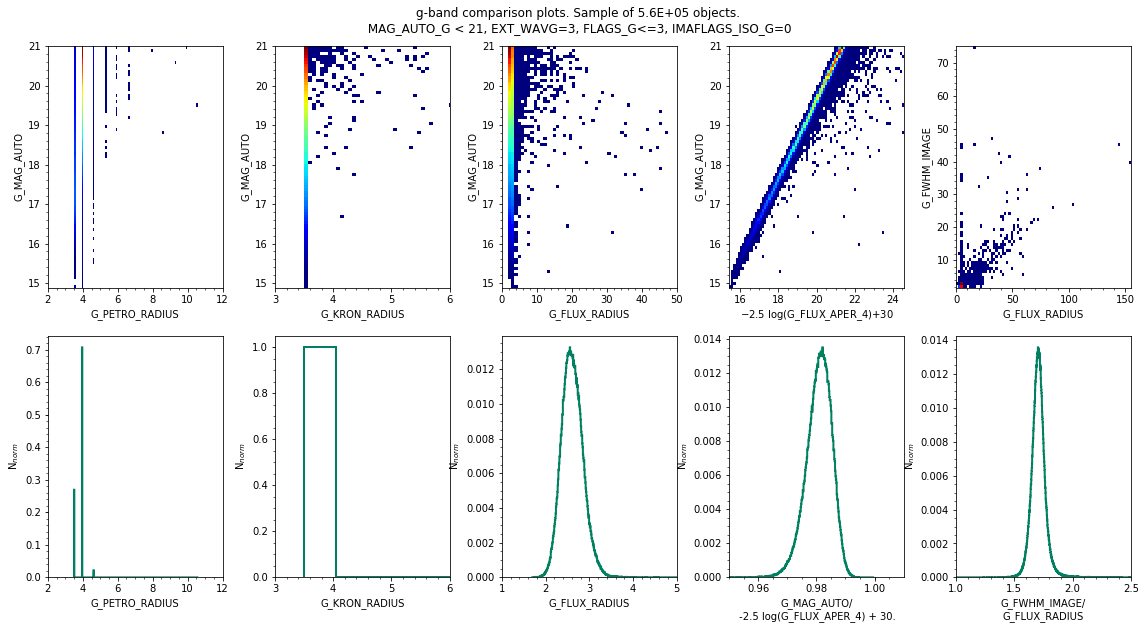

r: 1.6589966753902468 / 1.6592193783793374


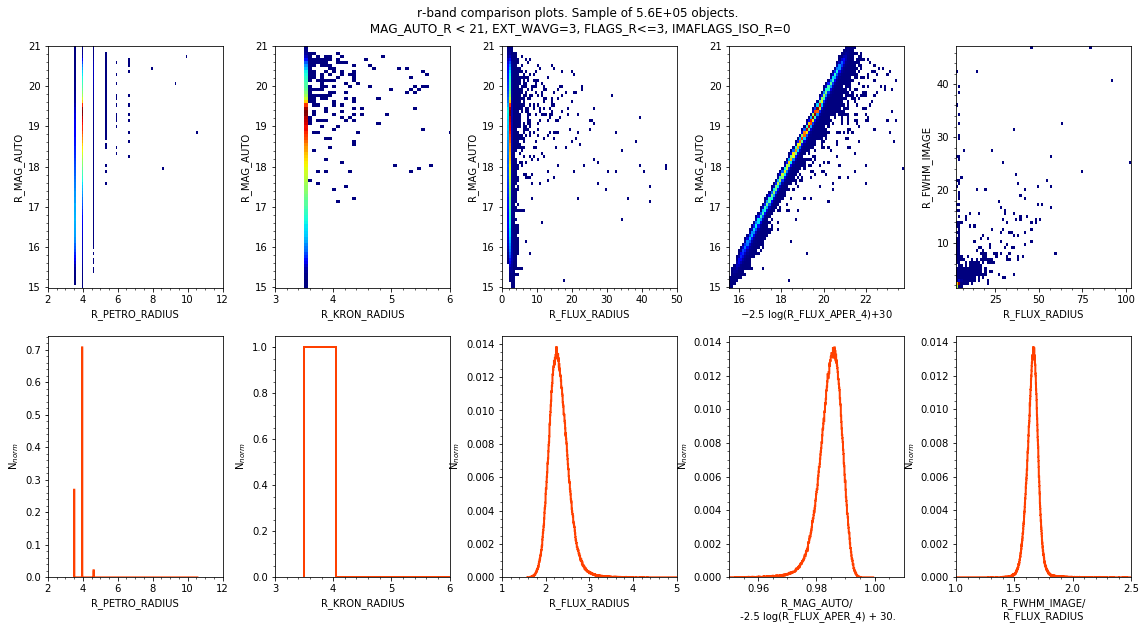

i: 1.6498824637669458 / 1.6481044276112071


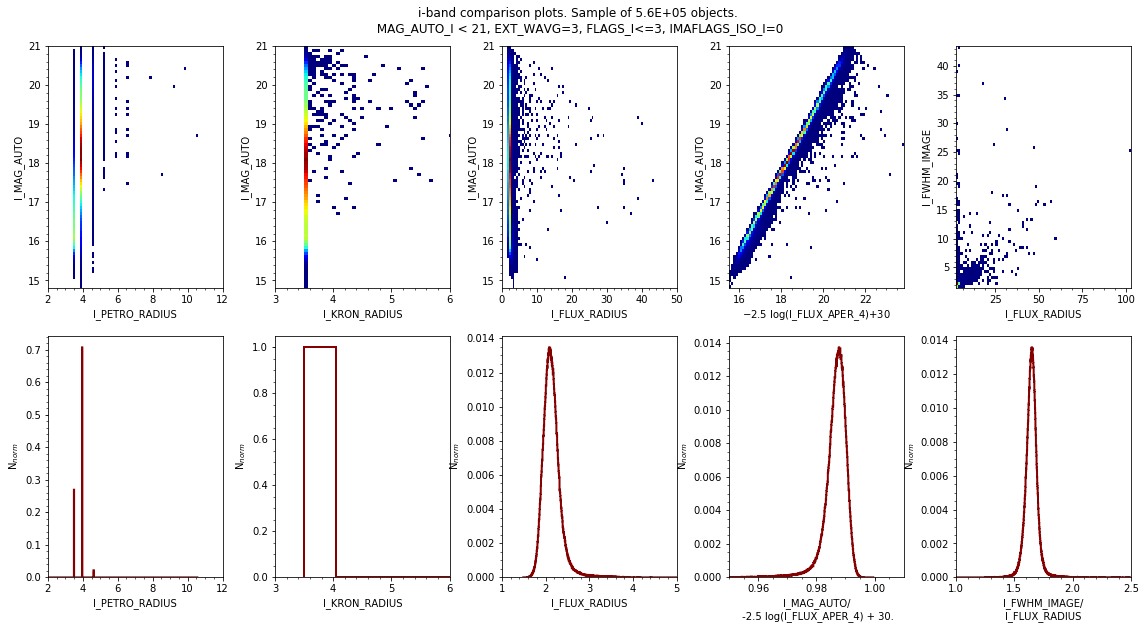

z: 1.624739610365043 / 1.6190791110591585


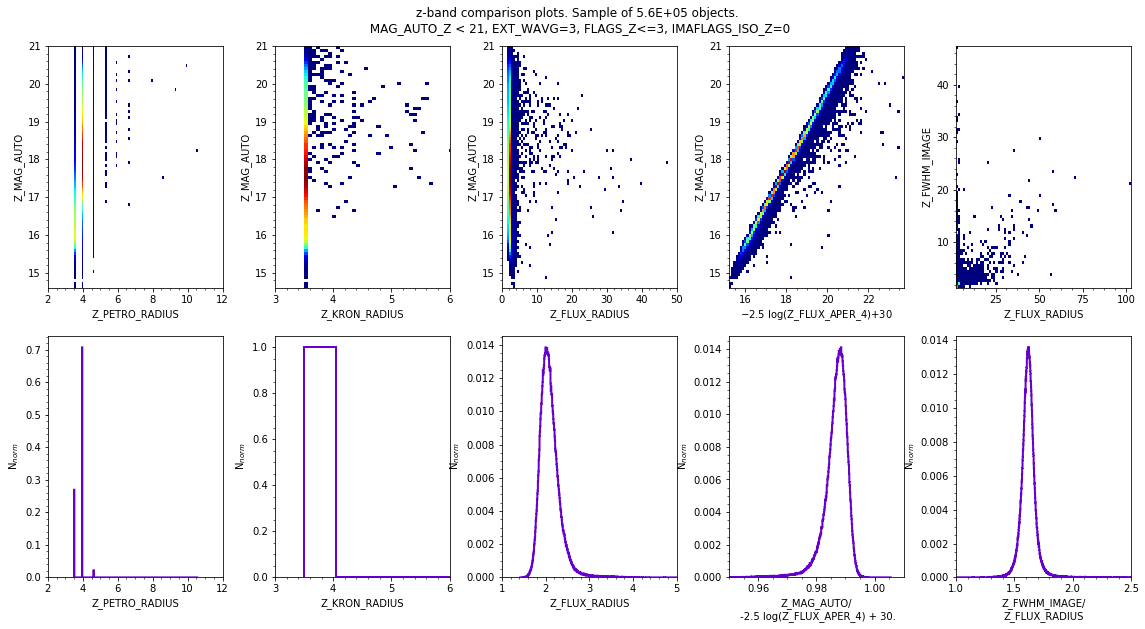

Y: 1.7378546706658005 / 1.5929312915833842


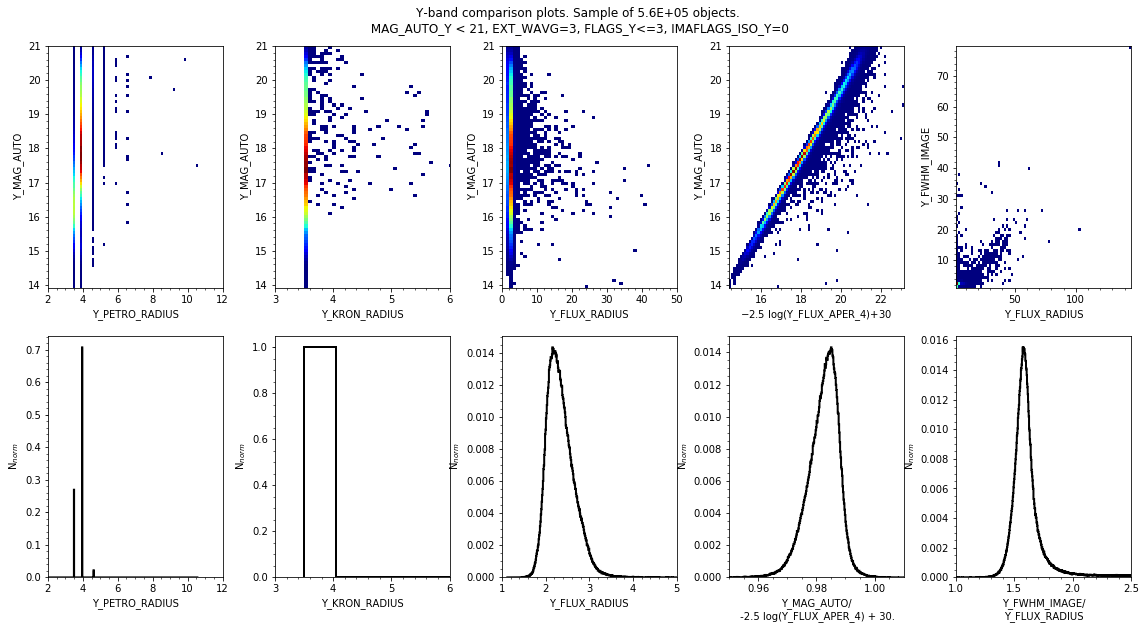

In [13]:
plot_var(df_aux0, CLASS=3, FLAGS=3)

### For Class Stars

g: 1.7104764837182909 / 1.705739584491268


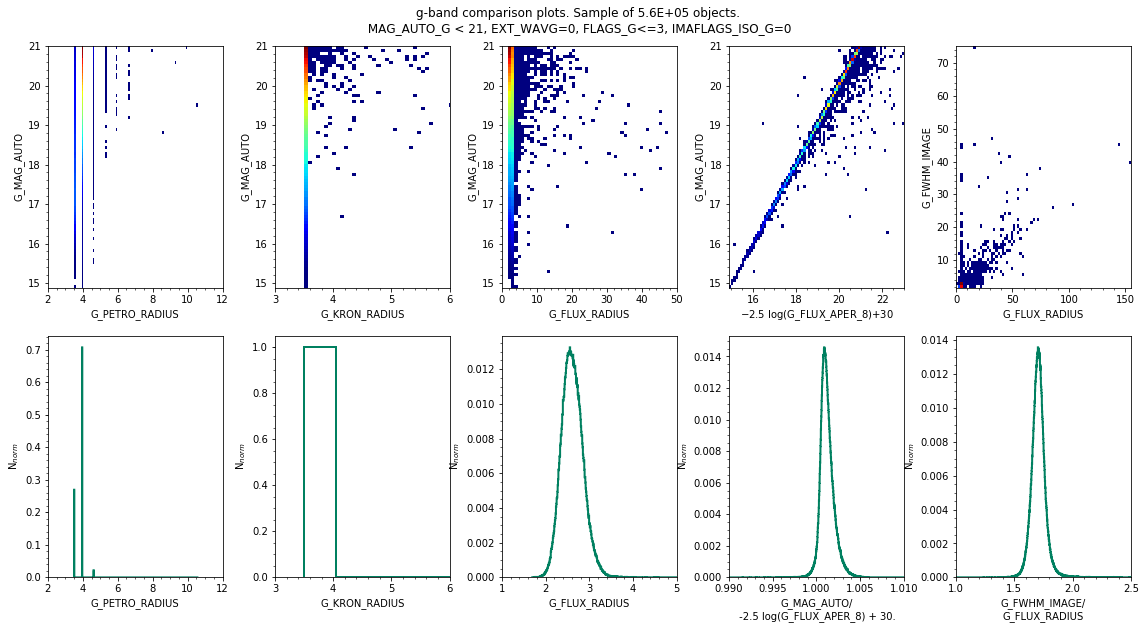

r: 1.6589966753902468 / 1.6592193783793374


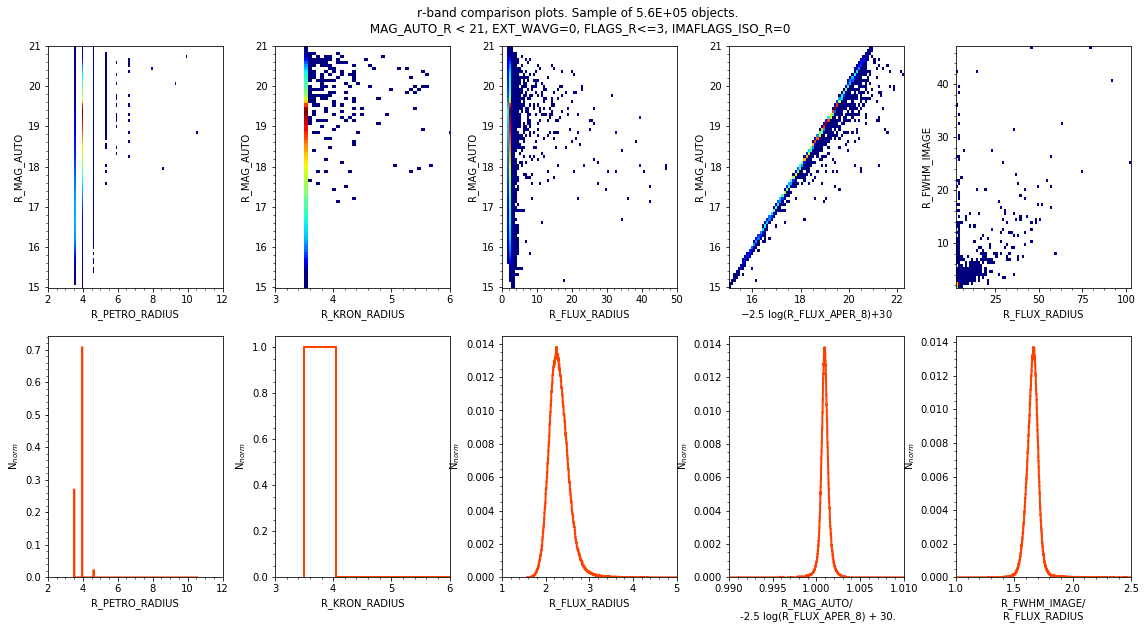

i: 1.6498824637669458 / 1.6481044276112071


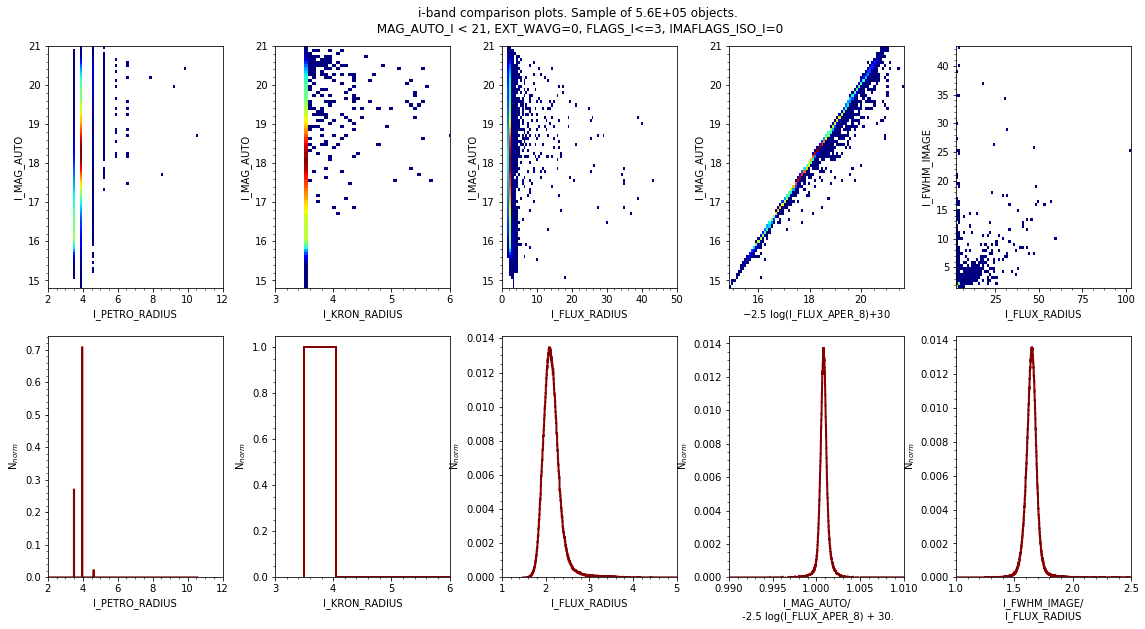

z: 1.624739610365043 / 1.6190791110591585


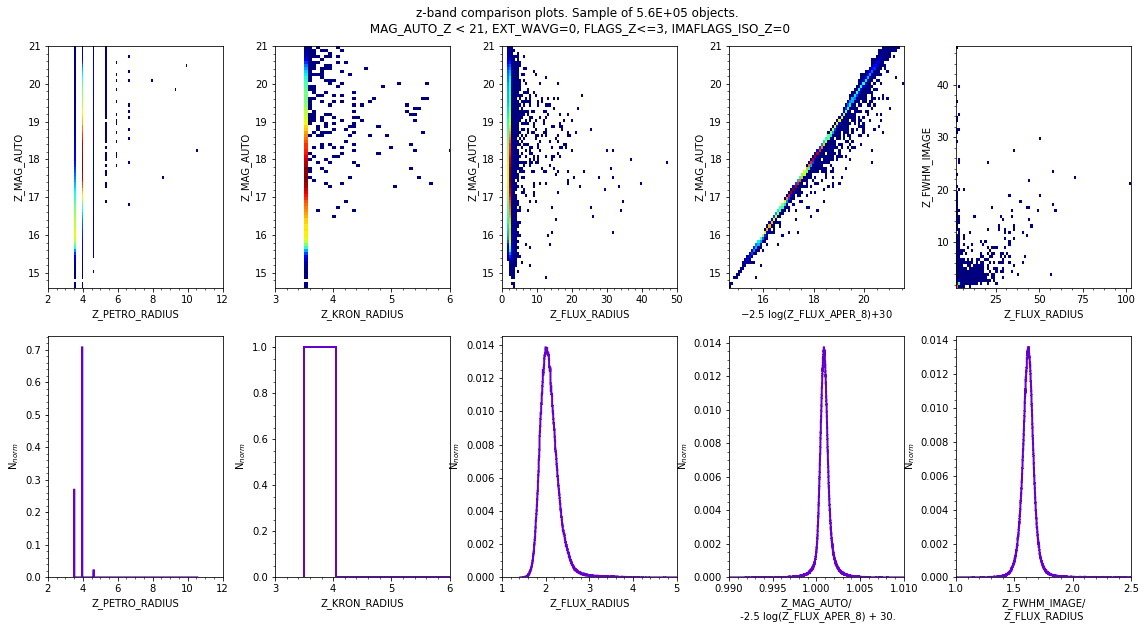

Y: 1.7378546706658005 / 1.5929312915833842


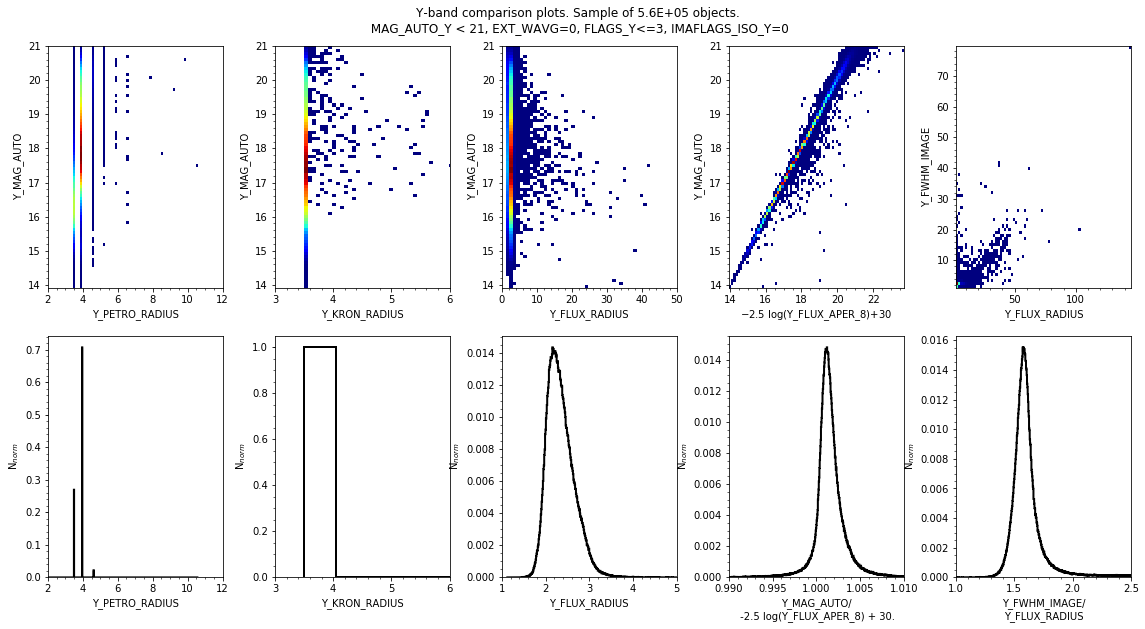

In [14]:
plot_var(df_aux0, CLASS=0, FLAGS=3)

In [16]:
2.355/0.675 /2 

1.7444444444444442